# Stage 1: Unseen Dataset Evaluation
## BERT + FP (Transformer Encoder + FP_AMPL) — LOS/NLOS Classification

Evaluates trained `stage1_bert_fp_best.pt` on **completely unseen** 4 scenarios (2400 samples).

In [ ]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "d_model": 64,
    "nhead": 4,
    "num_layers": 2,
    "dim_feedforward": 128,
    "input_size": 1,
    "fp_size": 3,
    "dropout": 0.2,
    "batch_size": 64,
    "seed": 42,
}

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


## 1 · Model Architecture

In [ ]:
class BERT_FP_Classifier(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=128, dropout=0.2, max_seq_len=60, fp_size=3):
        super().__init__()
        self.d_model = d_model

        self.input_proj = nn.Linear(input_size, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.fp_proj = nn.Linear(fp_size, d_model)
        # +2 for CLS + FP prefix token
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len + 2, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True, activation='gelu',
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def _encode(self, x_seq, fp_features=None):
        batch_size = x_seq.size(0)
        x = self.input_proj(x_seq)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        if fp_features is not None:
            fp_token = self.fp_proj(fp_features).unsqueeze(1)  # (B, 1, d_model)
            x = torch.cat([cls_tokens, fp_token, x], dim=1)   # [CLS, FP, CIR_1..60]
        else:
            x = torch.cat([cls_tokens, x], dim=1)             # [CLS, CIR_1..60]
        x = x + self.pos_embed[:, :x.size(1), :]
        return self.transformer(x)

    def forward(self, x_seq, fp_features=None, return_dynamics=False):
        h_all = self._encode(x_seq, fp_features)
        cls_out = self.norm(h_all[:, 0, :])
        pred = self.classifier(cls_out)
        if return_dynamics:
            return pred, h_all
        return pred

    def embed(self, x_seq, fp_features=None):
        h_all = self._encode(x_seq, fp_features)
        return self.norm(h_all[:, 0, :])

## 2 · Load Unseen Dataset

Same preprocessing as training. **Includes FP_AMPL1/2/3 extraction**.

In [4]:
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


def load_unseen_fp_dataset(filepath):
    """Load and preprocess the unseen dataset — CIR + FP_AMPL features."""
    PRE = CONFIG["pre_crop"]
    TOTAL = CONFIG["total_len"]

    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} rows from {filepath}")

    cir_cols = sorted(
        [c for c in df.columns if c.startswith("CIR")],
        key=lambda c: int(c.replace("CIR", ""))
    )

    X_list, y_list, fp_list = [], [], []
    source_files = []
    skipped = 0

    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc <= 0:
            skipped += 1
            continue
        sig = sig / rxpacc

        f1 = float(row.get('FP_AMPL1', 0)) / max(rxpacc, 1) / 64.0
        f2 = float(row.get('FP_AMPL2', 0)) / max(rxpacc, 1) / 64.0
        f3 = float(row.get('FP_AMPL3', 0)) / max(rxpacc, 1) / 64.0
        fp_list.append([f1, f2, f3])

        leading_edge = get_roi_alignment(sig)
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min = np.min(crop)
        local_max = np.max(crop)
        rng = local_max - local_min
        if rng > 0:
            crop = (crop - local_min) / rng
        else:
            crop = np.zeros(TOTAL)

        X_list.append(crop)
        y_list.append(float(row["Label"]))
        source_files.append(row["Source_File"])

    if skipped:
        print(f"Skipped {skipped} rows (bad RXPACC)")

    X = np.array(X_list, dtype=np.float32).reshape(-1, TOTAL, 1)
    y = np.array(y_list, dtype=np.float32)
    F = np.array(fp_list, dtype=np.float32)

    print(f"Preprocessed: {len(y)} samples  |  LOS: {int((y==0).sum())}  |  NLOS: {int((y==1).sum())}")
    return X, y, F, source_files

In [5]:
X_unseen, y_unseen, F_unseen, sources = load_unseen_fp_dataset(
    "../dataset/channels/unseen_dataset.csv"
)

Loaded 2400 rows from ../dataset/channels/unseen_dataset.csv
Preprocessed: 2400 samples  |  LOS: 1200  |  NLOS: 1200


## 3 · Load Trained Model

In [ ]:
model = BERT_FP_Classifier(
    input_size=CONFIG["input_size"], d_model=CONFIG["d_model"],
    nhead=CONFIG["nhead"], num_layers=CONFIG["num_layers"],
    dim_feedforward=CONFIG["dim_feedforward"], dropout=CONFIG["dropout"],
    max_seq_len=CONFIG["total_len"], fp_size=CONFIG["fp_size"],
).to(device)

state_dict = torch.load("stage1_bert_fp_best.pt", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()
print(f"Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

## 4 · Inference on Unseen Data

In [7]:
X_te = torch.tensor(X_unseen).to(device)
y_te = torch.tensor(y_unseen).unsqueeze(1).to(device)
F_te = torch.tensor(F_unseen).to(device)

with torch.no_grad():
    pred = model(X_te, fp_features=F_te)
    pred_binary = (pred > 0.5).float()
    accuracy = (pred_binary == y_te).float().mean().item()

pred_np = pred.cpu().numpy().flatten()
pred_label_np = (pred_np > 0.5).astype(float)
true_np = y_unseen.flatten()

print(f"Unseen Dataset Accuracy: {100 * accuracy:.2f}%")
print(f"{'='*50}")
print(classification_report(true_np, pred_label_np, target_names=["LOS", "NLOS"]))

Unseen Dataset Accuracy: 96.21%
              precision    recall  f1-score   support

         LOS       1.00      0.92      0.96      1200
        NLOS       0.93      1.00      0.96      1200

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



## 5 · Per-Scenario Breakdown

In [8]:
sources_arr = np.array(sources)
scenario_names = np.array(["_".join(s.split("_")[:2]) for s in sources_arr])
unique_scenarios = sorted(set(scenario_names))

print(f"{'Scenario':<16} {'Type':<6} {'Samples':>7} {'Correct':>8} {'Accuracy':>9}")
print("-" * 52)

for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_true = true_np[mask]
    s_pred = pred_label_np[mask]
    s_correct = (s_true == s_pred).sum()
    s_total = len(s_true)
    s_acc = s_correct / s_total * 100
    s_type = "NLOS" if "nlos" in scenario else "LOS"
    print(f"{scenario:<16} {s_type:<6} {s_total:>7} {s_correct:>8} {s_acc:>8.2f}%")

print("-" * 52)
print(f"{'TOTAL':<16} {'':6} {len(true_np):>7} {int((true_np == pred_label_np).sum()):>8} {100*accuracy:>8.2f}%")

Scenario         Type   Samples  Correct  Accuracy
----------------------------------------------------
10.19m_los       LOS        600      571    95.17%
8.91m_nlos       NLOS       600      600   100.00%
9.29m_los        LOS        600      538    89.67%
9.54m_nlos       NLOS       600      600   100.00%
----------------------------------------------------
TOTAL                      2400     2309    96.21%


## 6 · Confusion Matrix

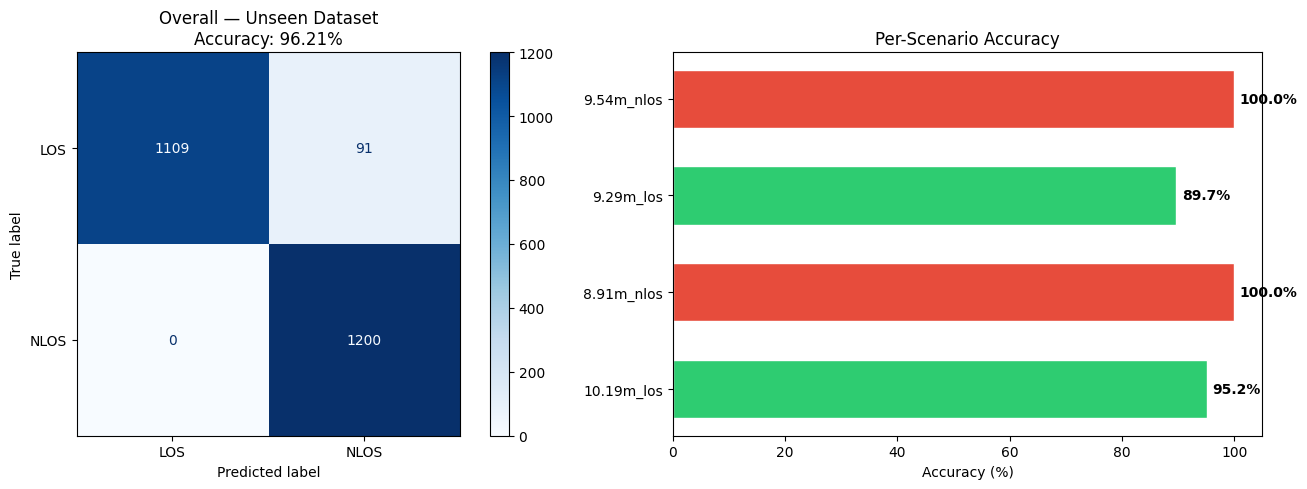

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Overall — Unseen Dataset\nAccuracy: {100*accuracy:.2f}%")

scenario_labels, scenario_accs, scenario_colors = [], [], []
for scenario in unique_scenarios:
    mask = scenario_names == scenario
    s_acc = (true_np[mask] == pred_label_np[mask]).mean() * 100
    scenario_labels.append(scenario)
    scenario_accs.append(s_acc)
    scenario_colors.append("#2ecc71" if "los" in scenario and "nlos" not in scenario else "#e74c3c")

bars = axes[1].barh(scenario_labels, scenario_accs, color=scenario_colors, edgecolor="white", height=0.6)
axes[1].set_xlim(0, 105)
axes[1].set_xlabel("Accuracy (%)")
axes[1].set_title("Per-Scenario Accuracy")
for bar, acc in zip(bars, scenario_accs):
    axes[1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f"{acc:.1f}%", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

## 7 · ROC Curve

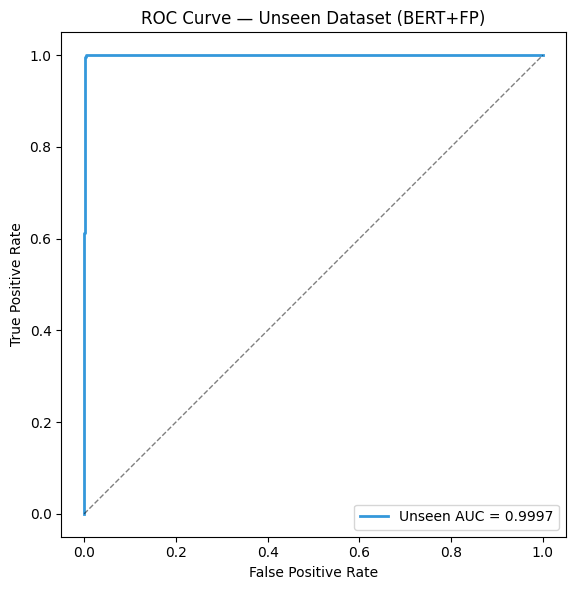

In [10]:
fpr, tpr, _ = roc_curve(true_np, pred_np)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color="#3498db", lw=2, label=f"Unseen AUC = {roc_auc:.4f}")
ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Unseen Dataset (BERT+FP)")
ax.legend(loc="lower right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 8 · Embedding Visualization

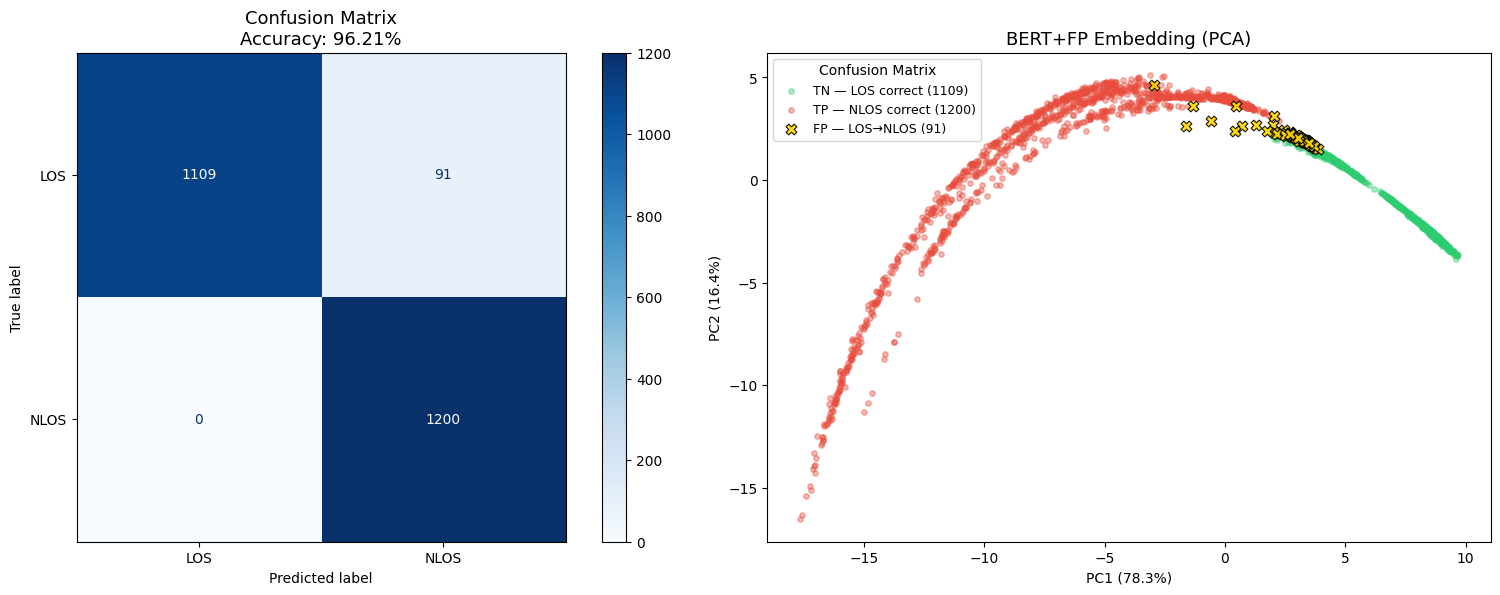

TN: 1109 | FP: 91 | TP: 1200 | FN: 0 | Total: 2400


In [11]:
los_mask = true_np == 0
nlos_mask = true_np == 1

with torch.no_grad():
    embeddings = model.embed(X_te, fp_features=F_te).cpu().numpy()

scaler = StandardScaler()
emb_scaled = scaler.fit_transform(embeddings)
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_scaled)

misclassified = true_np != pred_label_np
los_correct = los_mask & ~misclassified
los_wrong = los_mask & misclassified
nlos_correct = nlos_mask & ~misclassified
nlos_wrong = nlos_mask & misclassified

tn = int(los_correct.sum())
fp = int(los_wrong.sum())
tp = int(nlos_correct.sum())
fn = int(nlos_wrong.sum())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(true_np, pred_label_np)
disp = ConfusionMatrixDisplay(cm, display_labels=["LOS", "NLOS"])
disp.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title(f"Confusion Matrix\nAccuracy: {100*accuracy:.2f}%", fontsize=13)

ax = axes[1]
ax.scatter(emb_2d[los_correct, 0], emb_2d[los_correct, 1],
           c="#2ecc71", alpha=0.4, s=15, label=f"TN — LOS correct ({tn})", zorder=3)
ax.scatter(emb_2d[nlos_correct, 0], emb_2d[nlos_correct, 1],
           c="#e74c3c", alpha=0.4, s=15, label=f"TP — NLOS correct ({tp})", zorder=3)
if fp > 0:
    ax.scatter(emb_2d[los_wrong, 0], emb_2d[los_wrong, 1],
               c="gold", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FP — LOS\u2192NLOS ({fp})", zorder=7)
if fn > 0:
    ax.scatter(emb_2d[nlos_wrong, 0], emb_2d[nlos_wrong, 1],
               c="darkorange", marker='X', s=60, edgecolors='black', linewidths=0.8,
               alpha=0.9, label=f"FN — NLOS\u2192LOS ({fn})", zorder=7)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("BERT+FP Embedding (PCA)", fontsize=13)
ax.legend(loc="upper left", fontsize=9, title="Confusion Matrix", title_fontsize=10)

plt.tight_layout()
plt.show()

print(f"TN: {tn} | FP: {fp} | TP: {tp} | FN: {fn} | Total: {tn+fp+tp+fn}")

## 9 · Prediction Confidence Distribution

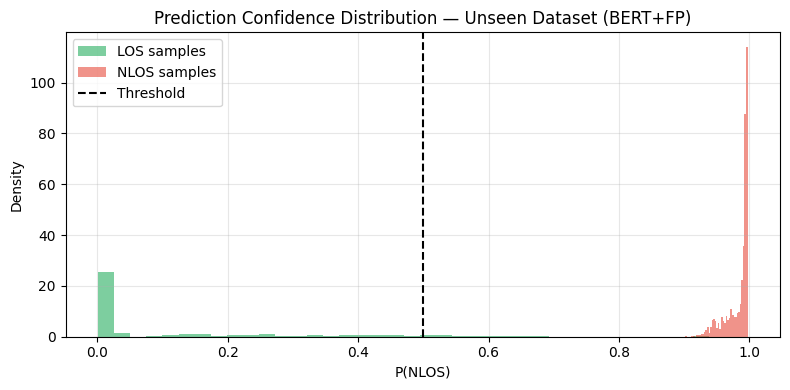

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(pred_np[true_np == 0], bins=40, alpha=0.6, color="#27ae60",
        label="LOS samples", density=True)
ax.hist(pred_np[true_np == 1], bins=40, alpha=0.6, color="#e74c3c",
        label="NLOS samples", density=True)
ax.axvline(0.5, color="black", ls="--", lw=1.5, label="Threshold")
ax.set_xlabel("P(NLOS)")
ax.set_ylabel("Density")
ax.set_title("Prediction Confidence Distribution — Unseen Dataset (BERT+FP)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10 · Misclassified Samples Analysis

In [13]:
misclassified = true_np != pred_label_np
n_wrong = misclassified.sum()

if n_wrong == 0:
    print("No misclassified samples — perfect accuracy on unseen data!")
else:
    print(f"Misclassified: {n_wrong} / {len(true_np)} ({100*n_wrong/len(true_np):.2f}%)")
    print(f"\n{'Source File':<28} {'True':>6} {'Pred':>6} {'P(NLOS)':>9}")
    print("-" * 55)

    mis_idx = np.where(misclassified)[0]
    for i in mis_idx[:30]:
        lbl = "NLOS" if true_np[i] == 1 else "LOS"
        plb = "NLOS" if pred_label_np[i] == 1 else "LOS"
        print(f"{sources[i]:<28} {lbl:>6} {plb:>6} {pred_np[i]:>9.4f}")

    if len(mis_idx) > 30:
        print(f"... and {len(mis_idx) - 30} more")

    print(f"\n{'Scenario':<16} {'Errors':>7} {'Total':>7} {'Error Rate':>11}")
    print("-" * 45)
    for scenario in unique_scenarios:
        mask = scenario_names == scenario
        errs = (true_np[mask] != pred_label_np[mask]).sum()
        total = mask.sum()
        if errs > 0:
            print(f"{scenario:<16} {errs:>7} {total:>7} {100*errs/total:>10.2f}%")

Misclassified: 91 / 2400 (3.79%)

Source File                    True   Pred   P(NLOS)
-------------------------------------------------------
9.29m_los_c2.csv                LOS   NLOS    0.6059
9.29m_los_c2.csv                LOS   NLOS    0.5108
9.29m_los_c2.csv                LOS   NLOS    0.6218
9.29m_los_c2.csv                LOS   NLOS    0.5820
9.29m_los_c2.csv                LOS   NLOS    0.5160
9.29m_los_c2.csv                LOS   NLOS    0.6166
9.29m_los_c2.csv                LOS   NLOS    0.5890
9.29m_los_c2.csv                LOS   NLOS    0.5339
9.29m_los_c2.csv                LOS   NLOS    0.5064
9.29m_los_c2.csv                LOS   NLOS    0.7410
9.29m_los_c2.csv                LOS   NLOS    0.7017
9.29m_los_c2.csv                LOS   NLOS    0.6562
9.29m_los_c2.csv                LOS   NLOS    0.6148
9.29m_los_c2.csv                LOS   NLOS    0.5414
9.29m_los_c2.csv                LOS   NLOS    0.5678
9.29m_los_c2.csv                LOS   NLOS    0.6857
9.29m_los

In [14]:
print("Unseen dataset evaluation complete.")

Unseen dataset evaluation complete.
